In [244]:
import pandas as pd

df = pd.read_csv("../data/raw/bina_az_raw.csv")
df.head()

,location,rooms,area_m2,price,url
0,"Elan №5765150 - Bakı, Nizami m., 3 otaqlı, 135...",3,135,1300,https://bina.az/items/5765150
1,"Elan №5738942 - Bakı, Azadlıq Prospekti m., 4 ...",4,100,830,https://bina.az/items/5738942
2,"Elan №5635979 - Bakı, Nəsimi r., 3 otaqlı, 155...",3,155,1500,https://bina.az/items/5635979
3,"Elan №5765146 - Bakı, Nəriman Nərimanov m., 3 ...",3,85,800,https://bina.az/items/5765146
4,"Elan №5758004 - Bakı, 28 May m., 2 otaqlı, 54 ...",2,54,800,https://bina.az/items/5758004


In [245]:
df.dropna(subset=["price"], inplace=True)
df.fillna("Unknown", inplace=True)

In [246]:
df = df[
    (df["price"] > 250) &
    (df["price"] < 5000) &
    (df["area_m2"] >= 40) &
    (df["rooms"] <= 6)
]

In [247]:
import re

def extract_floors(text):
    match = re.search(r'(\d+)/(\d+)\s*mərtəbə', text)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

df["floor"], df["total_floor"] = zip(*df["location"].apply(extract_floors))

In [248]:
# Yeni/Köhnə tikili 0/1
df["is_new_building"] = df["total_floor"].apply(lambda x: 1 if x >= 10 else 0)

In [249]:
# Otağa görə sahə
df["area_per_room"] = df["area_m2"] / df["rooms"]

In [250]:
def extract_place(text):
    try:
        parts = text.split("-")[1].split(",")
        return parts[1].strip()
    except:
        return "Unknown"

df["place"] = df["location"].apply(extract_place)

In [251]:
# Redundant sütun silmək
df = df.drop(columns=['url', 'location'])

In [252]:
# Train üçün X və y
features = ["rooms", "area_m2", "floor", "total_floor", "area_per_room", "is_new_building", "place"]
X = df[features]
y = df["price"]

In [262]:
# Yalnız X-dən: place sütununu One-Hot Encoding ilə rəqəmə çeviririk
X_encoded = pd.get_dummies(X, columns=["place"], drop_first=True)
numerical = ["rooms","area_m2","floor","total_floor","area_per_room","is_new_building"]
X_encoded[numerical] = StandardScaler().fit_transform(X_encoded[numerical])

In [254]:
# String → numeric: place sütunu One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=["place"], drop_first=True)

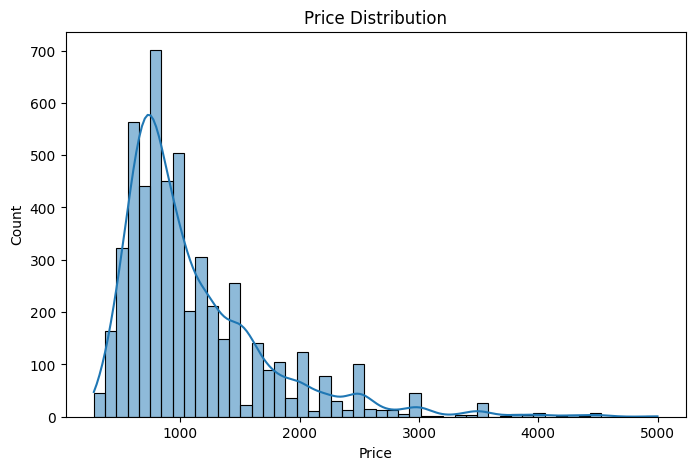

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

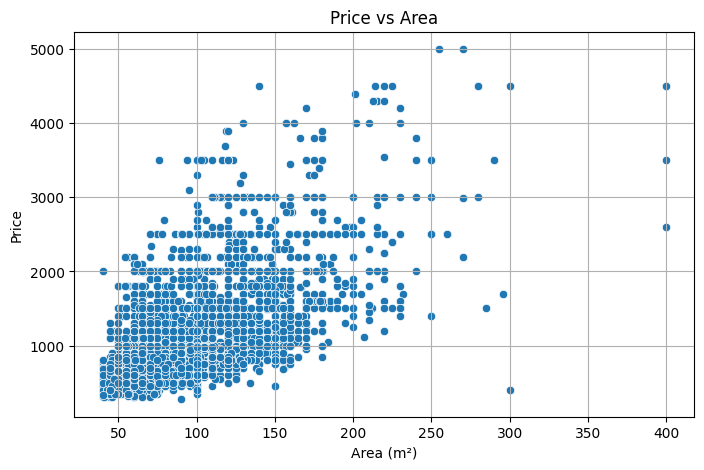

In [256]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df["area_m2"], y=df["price"])
plt.title("Price vs Area")
plt.xlabel("Area (m²)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

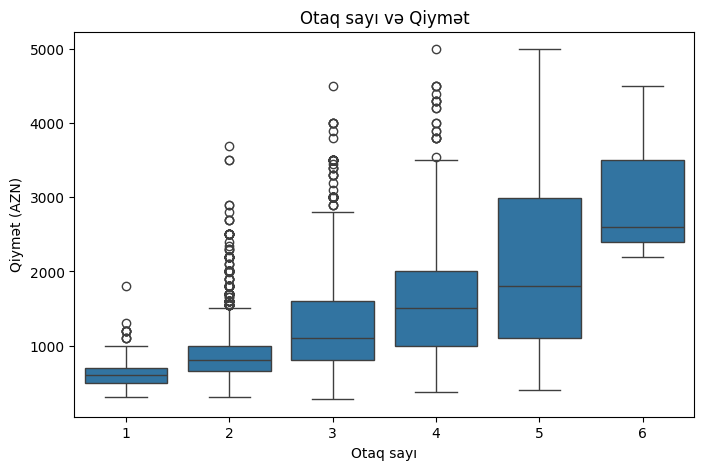

In [257]:
plt.figure(figsize=(8,5))
sns.boxplot(x='rooms', y='price', data=df)
plt.title("Otaq sayı və Qiymət")
plt.xlabel("Otaq sayı")
plt.ylabel("Qiymət (AZN)")
plt.show()

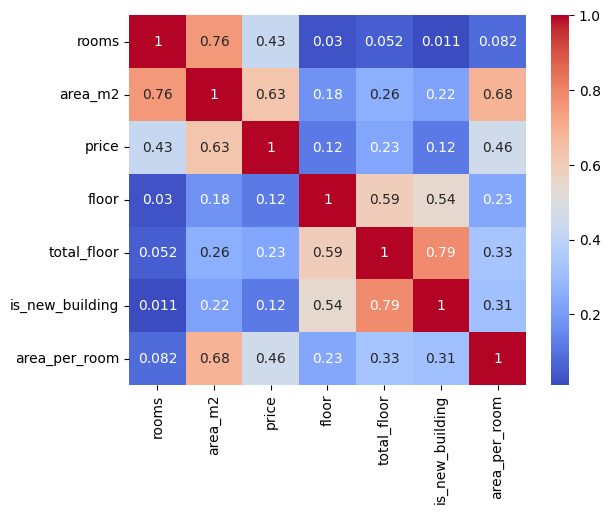

In [258]:
# Correlation matrix
df_numeric = df.select_dtypes(include='number')
corr = df_numeric.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

In [259]:
df.columns

Index(['rooms', 'area_m2', 'price', 'floor', 'total_floor', 'is_new_building',
       'area_per_room', 'place'],
      dtype='object')

In [263]:
df.to_csv("../data/processed/bina_az_clean.csv", index=False)

In [261]:
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
    ]
)